In [12]:
# Imports

import pandas as pd
import numpy as np
import warnings
from plotnine import *
from darts import TimeSeries
from darts.utils.statistics import plot_acf, check_seasonality, plot_residuals_analysis
from darts.models import NaiveSeasonal, NaiveDrift, NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape

warnings.filterwarnings('ignore')

In [2]:
# Read Data

filepath = 'data/AirPassengers.csv'
data = pd.read_csv(filepath)
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


<TimeSeries (DataArray) (month_start: 5, component: 1, sample: 1)>
array([[[112.]],

       [[118.]],

       [[132.]],

       [[129.]],

       [[121.]]])
Coordinates:
  * month_start  (month_start) datetime64[ns] 1949-01-01 ... 1949-05-01
  * component    (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
There is seasonality of order 12.


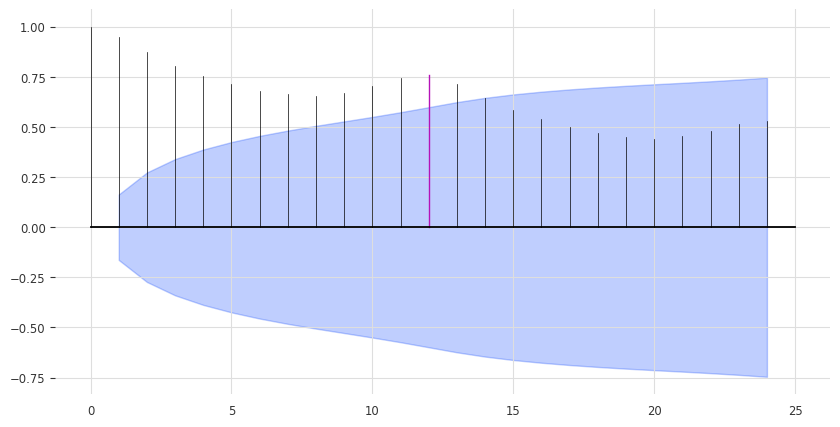

In [3]:
# Check Seasonality

data['month_start'] = pd.to_datetime(data['Month'])
darts_ts = TimeSeries.from_dataframe(data, time_col='month_start', value_cols='#Passengers')
print(darts_ts[0:5])

plot_acf(darts_ts, m=12, alpha=0.05)

for m in range(2, 25):
    is_seasonal, period = check_seasonality(darts_ts, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

In [4]:
TEST_SIZE = 24

train, test = darts_ts[:-24], darts_ts[-24:]
print(f'Length of Train Set {len(train)}')
print(f'Length of Test Set {len(test)}')

Length of Train Set 120
Length of Test Set 24


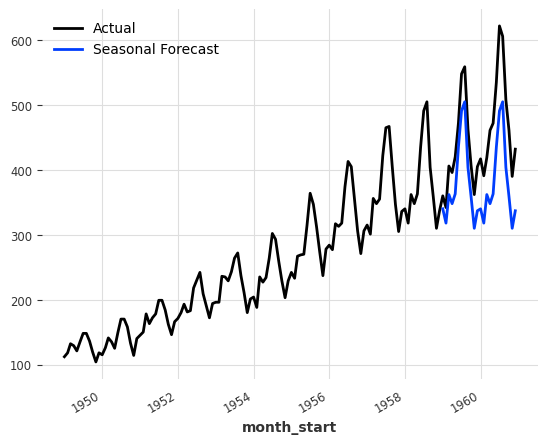

In [5]:
# Naive Seasonal

model = NaiveSeasonal(K=12)
model.fit(train)
seasonal_forecast = model.predict(n=TEST_SIZE)

darts_ts.plot(label='Actual')
seasonal_forecast.plot(label='Seasonal Forecast')

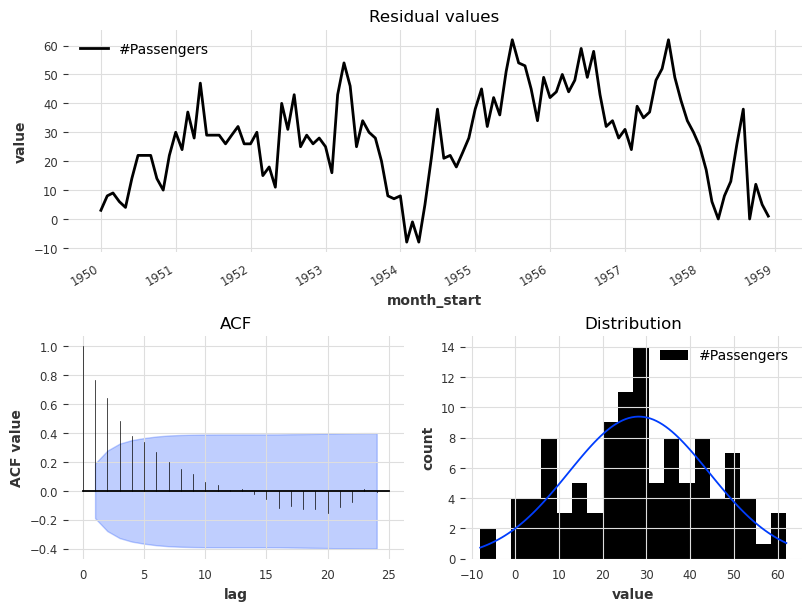

In [6]:
plot_residuals_analysis(model.residuals(train))

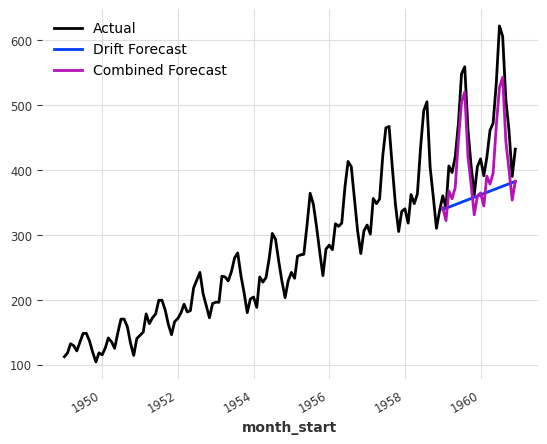

In [7]:
# Naive Drift

model = NaiveDrift()
model.fit(train)
drift_forecast = model.predict(n=TEST_SIZE)

darts_ts.plot(label='Actual')
drift_forecast.plot(label='Drift Forecast')

combined_forecast = seasonal_forecast + drift_forecast - train[-1].values()[0][0]
combined_forecast.plot(label='Combined Forecast')

In [8]:
# Error Metrics

print(f'MAPE Drift Forecast {round(mape(test, drift_forecast), 2)}%')
print(f'MAPE Seasonal Forecast {round(mape(test, seasonal_forecast), 2)}%')
print(f'MAPE Combined Forecast {round(mape(test, combined_forecast), 2)}%')

MAPE Drift Forecast 18.41%
MAPE Seasonal Forecast 15.52%
MAPE Combined Forecast 10.35%


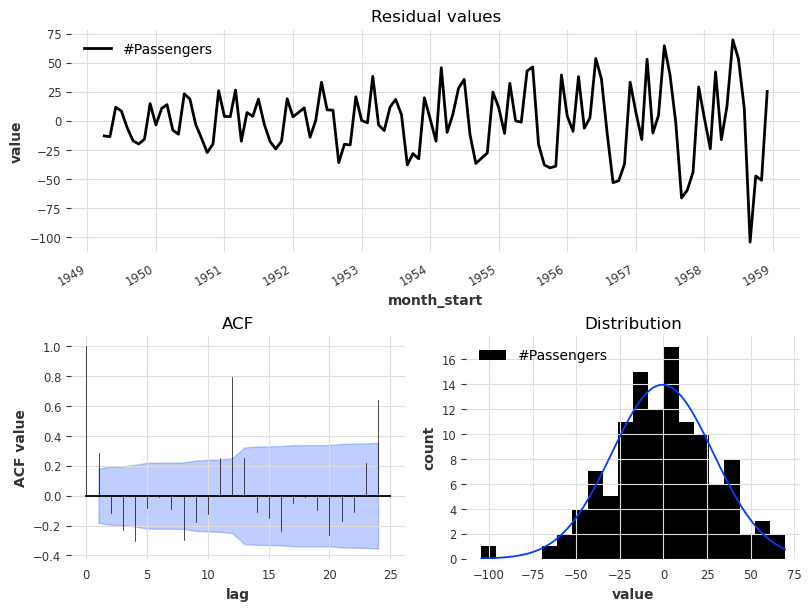

In [9]:
# Residual Analysis

plot_residuals_analysis(model.residuals(train)) # Naive Drift

In [10]:
# NBeats Model

model = NBEATSModel(input_chunk_length=24, 
                    output_chunk_length=12, 
                    random_state=42)
                    
model.fit([train], epochs=50, verbose=True);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 3/3 [00:00<00:00,  7.44it/s, train_loss=227.0]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00,  7.41it/s, train_loss=227.0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.04it/s]
MAPE NBEATS Forecast 4.21%


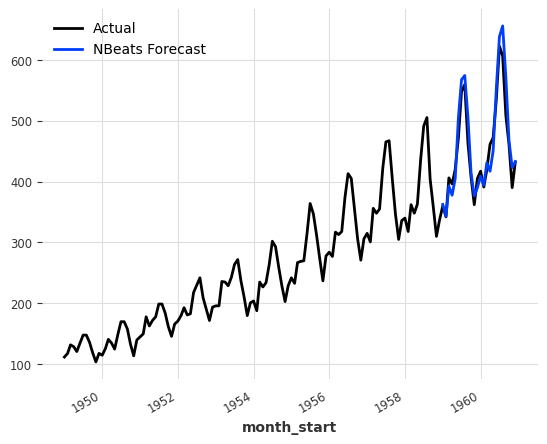

In [11]:
nbeats_forecast = model.predict(series=train, n=24)

darts_ts.plot(label='Actual')
nbeats_forecast.plot(label='NBeats Forecast')

print(f'MAPE NBEATS Forecast {round(mape(test, nbeats_forecast), 2)}%')

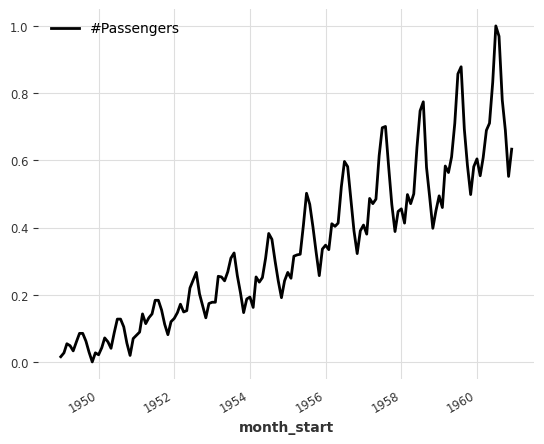

In [19]:
# Scaled Input Time Series

scaler = Scaler()
scaled_ts = scaler.fit_transform(darts_ts)
scaled_ts.plot()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 3/3 [00:00<00:00,  7.29it/s, train_loss=0.000689]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00,  7.26it/s, train_loss=0.000689]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.72it/s]
MAPE NBEATS Forecast 11%


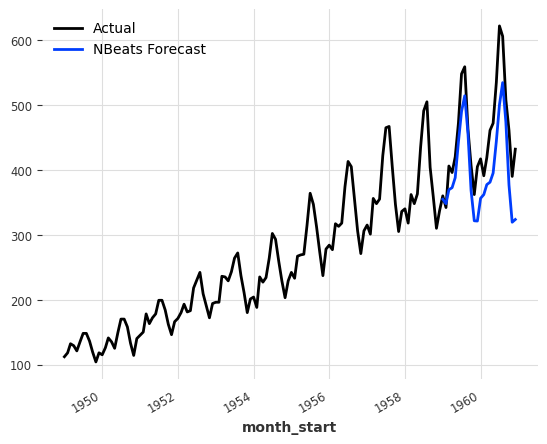

In [23]:
# Fitting Model on Scaled Time Series

scaled_train, scaled_test = scaled_ts[:-24], scaled_ts[-24:]
model = NBEATSModel(input_chunk_length=24, 
                    output_chunk_length=12, 
                    random_state=42)
                    
model.fit([scaled_train], epochs=50, verbose=True);
nbeats_scaled_forecast = model.predict(series=scaled_train, n=24)
nbeats_forecast = scaler.inverse_transform(nbeats_scaled_forecast)

darts_ts.plot(label='Actual')
nbeats_forecast.plot(label='NBeats Forecast')

mape_metric = mape(scaler.inverse_transform(scaled_test), nbeats_forecast)
print(f'MAPE NBEATS Forecast {round(mape_metric)}%')
